# Pathology Deep Learning Hands-On

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KatherLab/stamp_demo/blob/master/stamp_hands_on.ipynb)

Welcome to the 2025 Clinicum Digitale digital pathology hands-on session.
In this session we will have a look at what a typical machine learning workflow in our lab looks like.
We will predict the TP53 gene alteration in breast cancer from histopathologic whole-slide images.

# Prerequisites

## 1. Change runtime type
First, switch to a GPU-enabled Colab runtime: within Google Colab, go to *Runtime* $\to$ *Change runtime type*, and select **, as indicated in the screenshot below.

<img src="https://github.com/georg-wolflein/stamp_hands_on/blob/main/docs/colab_runtime.png?raw=true" width=500 />

## 2. Install dependencies
Here, we will install [STAMP](https://github.com/KatherLab/STAMP), a pipeline for computational pathology developed in [our lab](https://jnkather.github.io/).

In [1]:
#!pip install "stamp @ git+https://github.com/KatherLab/STAMP"
!pip uninstall -y stamp
!pip install "stamp @ git+https://github.com/KatherLab/STAMP@feature/validation-config"
!pip uninstall -y pandas numpy && pip install pandas numpy --upgrade

Found existing installation: stamp 2.0.0
Uninstalling stamp-2.0.0:
  Successfully uninstalled stamp-2.0.0
  Cloning https://github.com/KatherLab/STAMP (to revision feature/validation-config) to /tmp/pip-install-164zlzlk/stamp_fb31f567cec447bb9931eb85bf746cd9
  Running command git clone --filter=blob:none --quiet https://github.com/KatherLab/STAMP /tmp/pip-install-164zlzlk/stamp_fb31f567cec447bb9931eb85bf746cd9
  Running command git checkout -b feature/validation-config --track origin/feature/validation-config
  Switched to a new branch 'feature/validation-config'
  Branch 'feature/validation-config' set up to track remote branch 'feature/validation-config' from 'origin'.
  Resolved https://github.com/KatherLab/STAMP to commit ed2b58a7149c86f1381c7d69f759c8dc0c393da4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for stamp: filename=stamp-2.0.0-py3-none-any.whl size=68911 sha256=dbc94

In [2]:
import requests
from tqdm.notebook import tqdm
from pathlib import Path
import hashlib

## 3. Download data
Let's download our dataset of extracted features. This will take a few minutes.

In [3]:
_DOWNLOAD_PARTS = {
    "TCGA_BRCA_10x_UNI_features.tar.gz.part_aa": "6ff1600f3dcdc6344d3a5c46eca481c4",
    "TCGA_BRCA_10x_UNI_features.tar.gz.part_ab": "7b4c7bb21ac365ee86be86e10f6e4efa",
}


def md5(fname: str, chunk_size=8192) -> str:
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        while chunk := f.read(chunk_size):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()


def download(url: str, output_file: Path, checksum: str, chunk_size=1024):
    if output_file.exists():
        if md5(output_file) == checksum:
            print(f"{output_file} already downloaded, skipping...")
            return
        else:
            output_file.unlink()

    resp = requests.get(url, stream=True)
    total = int(resp.headers.get("content-length", 0))
    with (
        output_file.open("wb") as f,
        tqdm(
            desc=str(output_file),
            total=total,
            unit="iB",
            unit_scale=True,
            unit_divisor=1024,
        ) as bar,
    ):
        for data in resp.iter_content(chunk_size=chunk_size):
            size = f.write(data)
            bar.update(size)


if not Path("TCGA_BRCA_10x_UNI_features.tar.gz").exists():
    for filename, checksum in _DOWNLOAD_PARTS.items():
        download(
            f"https://github.com/KatherLab/stamp_demo/releases/download/data-release/{filename}",
            Path(filename),
            checksum,
        )

    !cat TCGA_BRCA_10x_UNI_features.tar.gz.part_* > TCGA_BRCA_10x_UNI_features.tar.gz

Now, let's extract the tar archive.

In [4]:
!test -d TCGA_BRCA_10x_UNI_features || \
    (mkdir -p TCGA_BRCA_10x_UNI_features && \
     tar -xzf TCGA_BRCA_10x_UNI_features.tar.gz -C TCGA_BRCA_10x_UNI_features)

As a sanity check, ensure there are exactly `242` files.

In [5]:
!ls TCGA_BRCA_10x_UNI_features | wc -l

242


# Overview

## From whole slide image to classification output

In this notebook, we will train a deep learning model to classify whole slide images (WSIs).
To do this, we follow the following structure:
$$
\mathbb{R}^{H \times W \times 3}
\xrightarrow{\text{tiling}} \mathbb{R}^{n \times p \times p \times 3}
\xrightarrow{\text{extract features}} \mathbb{R}^{n \times d}
\xrightarrow{\text{aggregate}} \mathbb{R}^{1 \times d}
\xrightarrow{\text{classify}} [0, 1]
$$
where $H,W$ are the dimensions of the original whole slide image,
$p=224$ is the patch size, and
$d=1024$ is the dimensionality of the feature extractor.

<img src="https://github.com/georg-wolflein/good-features/blob/master/assets/overview.png?raw=true" width=800 />


For simplicity, we will only do the **downstream training** part in this notebook.


## The structure of our data

Let's first have a look at our data.
The dataset we are using today consists of three major components:

1. The clini table contains clinical data for each patient
2. The slide table maps each slide a patient
3. The slide features contain a condensed, machine-learning-ready representation of the slides

### Clini table

The clini table contains clinical information for each patient.
Each row of the clini table describes exactly one patient.

* The column `PATIENT` contains a patient ID in the form `TCGA-site-patient` (`site` tells us which hostpital the patient is from)
* The remaining columns contain other clinical information on the patient
  * Among these, the `TP53` column indicates if there is a mutation of TP53. We will try to predict this.

In [6]:
!test -f TCGA-BRCA-DX_CLINI.csv || wget https://raw.githubusercontent.com/KatherLab/stamp_demo/refs/heads/master/TCGA-BRCA-DX_CLINI.csv -q -O TCGA-BRCA-DX_CLINI.csv

import pandas as pd
clini_df = pd.read_csv("TCGA-BRCA-DX_CLINI.csv")
clini_df

,PATIENT,ajcc_pathologic_stage,gender,TP53
0,TCGA-AN-A0FJ,Stage IV,female,1
1,TCGA-AN-A0FF,Stage IA,female,0
2,TCGA-AN-A0FD,Stage IIA,female,0
3,TCGA-AN-A0AT,Stage IIA,female,0
4,TCGA-AN-A0AS,Stage IIIA,female,1
...,...,...,...,...
1079,TCGA-E9-A54Y,Stage IIIA,female,0
1080,TCGA-E9-A54X,Stage IA,female,0
1081,TCGA-E9-A3X8,Stage IIB,female,0
1082,TCGA-E9-A3QA,Stage IIA,female,0


### Slide table
We often have multiple slides per patient.
The slide table matches each slide to its patient.
If a patient has multiple slides, it will appear multiple times, once for each slide they have.

In [7]:
!test -f TCGA-BRCA-DX_SLIDE.csv || wget https://raw.githubusercontent.com/KatherLab/stamp_demo/refs/heads/master/TCGA-BRCA-DX_SLIDE.csv -q -O TCGA-BRCA-DX_SLIDE.csv
slide_df = pd.read_csv("TCGA-BRCA-DX_SLIDE.csv")
slide_df

,PATIENT,FILENAME
0,TCGA-3C-AALI,TCGA-3C-AALI-01Z-00-DX1.F6E9A5DF-D8FB-45CF-B4B...
1,TCGA-3C-AALI,TCGA-3C-AALI-01Z-00-DX2.CF4496E0-AB52-4F3E-BDF...
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01Z-00-DX1.777C0957-255A-42F0-9EE...
3,TCGA-3C-AALJ,TCGA-3C-AALJ-01Z-00-DX2.62DFE56B-B84C-40F9-962...
4,TCGA-3C-AALK,TCGA-3C-AALK-01Z-00-DX1.4E6EB156-BB19-410F-878...
...,...,...
1128,TCGA-WT-AB44,TCGA-WT-AB44-01Z-00-DX1.B6ECEA7C-DA26-4B34-88C...
1129,TCGA-XX-A899,TCGA-XX-A899-01Z-00-DX1.08FE27B7-73B8-4CE3-ACF...
1130,TCGA-XX-A89A,TCGA-XX-A89A-01Z-00-DX1.671E2AD6-4D1A-4579-88C...
1131,TCGA-Z7-A8R5,TCGA-Z7-A8R5-01Z-00-DX1.3BDB407F-514C-4131-B05...


In [8]:
for _, row in (
    slide_df.groupby("PATIENT").nunique().value_counts().reset_index().iterrows()
):
    print(f"{row['count']:3d} patients have {row['FILENAME']} slides")

996 patients have 1 slides
 62 patients have 2 slides
  3 patients have 3 slides
  1 patients have 4 slides


### Features
Finally, we have the slide features themselves.
Since whole slide images are large, too large to do machine learning on them directly, we first reduce them to a more managable form with a feature extractor.
The feature extractor is itself a neural network.
It takes a whole slide image and reduces it to a more condensed form.
While the exact mechanism by which it does so is outside the scope of this course, it compresses the size of an input 10-fold, allowing us to use neural networks to analyze them.

Since this process does take quite some time, we have already extracted the features for today's dataset in advance.
Let's have a look at the features for one particular whole slide image.

Below is a thumbnail of this WSI. We removed background areas (shown in red).

![Slide Image](https://raw.githubusercontent.com/KatherLab/stamp_demo/refs/heads/master/TCGA-BH-A0HU-01Z-00-DX1.73B38904-E4F8-4F45-BD75-A27EC833B6DE.jpg)

In [9]:
import h5py

with h5py.File(
    "TCGA_BRCA_10x_UNI_features/TCGA-BH-A0HU-01Z-00-DX1.73B38904-E4F8-4F45-BD75-A27EC833B6DE.h5",
    "r",
) as f:
    feats = f["feats"][:]
    coords = f["coords"][:]
    print("Shape of features array:", feats.shape)
    print("Shape of coordinates array:", coords.shape)


Shape of features array: (5597, 1024)
Shape of coordinates array: (5597, 2)


As we can see, we have $n=5597$ feature vectors in this slide. This means that the WSI was split into 5597 patches. From each patch, we extracted a $d=1024$ dimensional feature vector.

#### Features
Let's have a look at one of the feature vectors. As we will see, it consists of 1024 floating point numbers.

[ 0.788  -2.107   1.562  ... -1.627  -1.902  -0.3203]


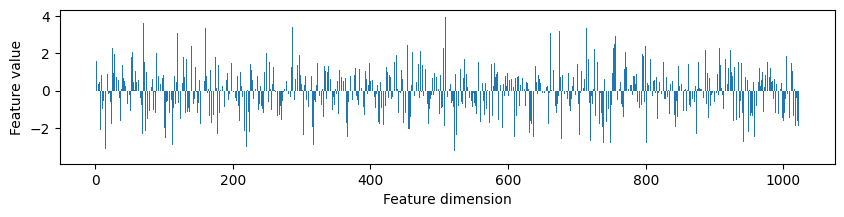

In [10]:
import matplotlib.pyplot as plt

print(feats[0])
plt.figure(figsize=(10, 2))
plt.bar(range(1024), feats[0])
plt.xlabel("Feature dimension")
plt.ylabel("Feature value")
pass

#### Coordinates
Let's also visualize the coordinates of the patches. We will see the shape of the WSI. Compare this to the image of the WSI above.


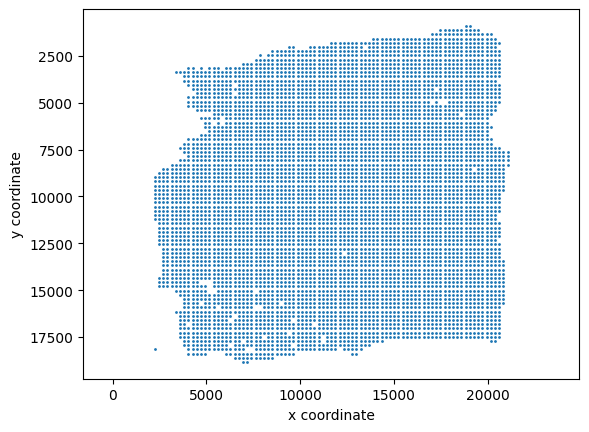

In [11]:
plt.plot(coords[:, 0], coords[:, 1], "o", markersize=1)
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.gca().invert_yaxis()
plt.axis("equal")
pass

## Splitting our data

We will split our dataset into two subsets: one part for training, one for testing.
Specifically, we will use patients from the largest site as the training set and the second largest site as the test set.

Often times, pathological slides contain artifacts like staining differences that make it possible to infer where slides originate from.
If certain hospitals have for example a higher rate of severe cases, the network may be base its prediction based on these artifacts instead of actually medically relevant features.
By ensuring that our testing set is from another site, we will be able to determine if our network is able to generalize to new sites.

In [12]:
site = clini_df["PATIENT"].str.split("-", expand=True)[1]
train_clini_df = clini_df[site == "BH"]
test_clini_df = clini_df[site == "A2"]

train_clini_df.to_csv("TCGA-BRCA-DX_CLINI_train.csv", index=False)
test_clini_df.to_csv("TCGA-BRCA-DX_CLINI_test.csv", index=False)

print(f"Training set: {len(train_clini_df)} patients")
print(f"Testing set: {len(test_clini_df)} patients")
train_clini_df

Training set: 150 patients
Testing set: 101 patients


,PATIENT,ajcc_pathologic_stage,gender,TP53
309,TCGA-BH-A1ES,Stage IIB,female,0
310,TCGA-BH-A1EO,Stage IIA,female,0
311,TCGA-BH-A1EN,Stage IIA,female,0
312,TCGA-BH-A18V,Stage IIB,female,1
313,TCGA-BH-A18U,Stage IIIA,female,1
...,...,...,...,...
922,TCGA-BH-A1EX,Stage IIB,female,0
923,TCGA-BH-A1EW,Stage IIA,female,0
924,TCGA-BH-A1EV,Stage IIIA,female,0
925,TCGA-BH-A1EU,Stage I,female,0


## Inspecting our data

Before starting training any models, it is often worth it to inspect the data to ensure that there are no glaring problems with it.
Let's look at the TP53 column.

In [13]:
train_clini_df["TP53"].value_counts()

,count
TP53,
0,103
1,47


As we can see, one class is less frequent than the other.
This can lead to problems while training our network.
Why becomes intuitively apparent if you consider a strongly imbalanced dataset with only two classes, one making up 90% of the dataset.
The network can trivially reach an accuracy of 90% by just always chosing the more frequent class.

One approach to combat this is to weigh the classes.
In STAMP, the classes are automatically weighed in such a way that each class has the overall same contribution.
For a nine-to-one imbalanced two-class dataset, each instance of the rare class would thus be weighted as having nine times the importance of a sample of the more common class.

This can of course still lead to instabilities in training, especially if one of the rare classes is one we don't particularly care about.
In that case the network may spend too much time learning how to correctly classify the unimportant class at the cost of more interesting classes.

However, we should be fine here because the imbalance isn't too severe.


## Training a Model

We will now train our model.

Let's store our results in a folder named the same as our target, i.e. "Grade without G1"

In [14]:
from pathlib import Path

output_dir = Path("output")
output_dir.mkdir(exist_ok=True, parents=True)
output_dir

PosixPath('output')

In [15]:
import os
from pathlib import Path
from stamp.modeling.train import train_categorical_model_
import torch

#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

train_result = train_categorical_model_(
    output_dir=output_dir,
    clini_table=Path("TCGA-BRCA-DX_CLINI_train.csv"),
    slide_table=Path("TCGA-BRCA-DX_SLIDE.csv"),
    feature_dir=Path("TCGA_BRCA_10x_UNI_features"),
    patient_label="PATIENT",
    ground_truth_label="TP53",
    filename_label="FILENAME",
    categories=["0", "1"],
    # Dataset and -loader parameters
    bag_size=512,
    val_bag_size=2048,
    num_workers=min(os.cpu_count() or 1, 16),
    # Training paramenters
    batch_size=64,
    max_epochs=64,
    patience=16,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    # Experimental features
    use_vary_precision_transform=False,
    use_alibi=False,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name               | Type              | Params | Mode 
-----------------------------------------------------------------
0 | vision_transformer | VisionTransformer | 6.8 M  | train
1 | valid_auroc        | MulticlassAUROC   | 0      | train
-----------------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.329    Total estimated model params size (MB)
35        Modules in train mode
0        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='epoch'>

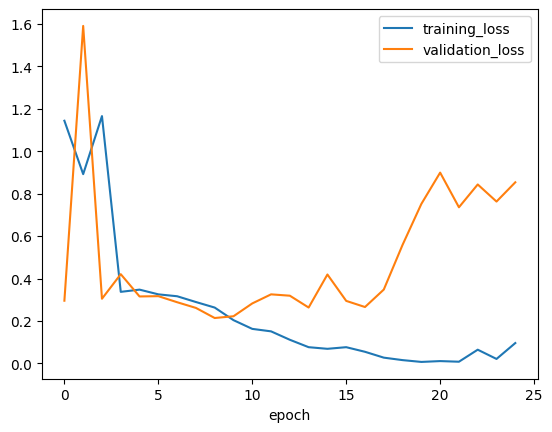

In [16]:
import matplotlib.pyplot as plt

lightning_logs_dir = sorted(output_dir.joinpath("lightning_logs").glob("version_*"))[-1]

history = pd.read_csv(lightning_logs_dir / "metrics.csv")
history = history.groupby(["epoch", "step"]).first().reset_index()
history.plot(x="epoch", y=["training_loss", "validation_loss"])

As we can see, the training loss decreases a lot faster and further than the validation loss.
This is to be expected:
since the network is trained on the training set, it does not only learn to recognize features relevant for classifying the target, but also learns to recognize the training images themselves.

Many of the features the network learns will not generalize.
In general, the longer we train a network, the more likely it is that it will pick up small, non-generalizing details uniquely identifying a singular image from the training set.
This is why we have a validation set:
By checking how well the network performs on the validation set, we can determine whether the network is still learning generalizable features.

Text(0.5, 0, 'Epoch')

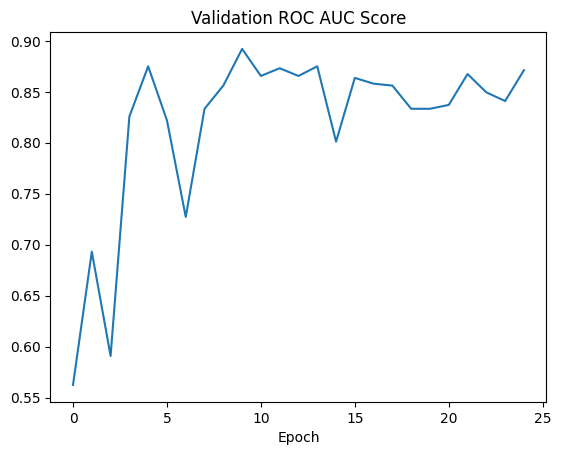

In [20]:
plt.plot(history.validation_auroc)
plt.title("Validation ROC AUC Score")
plt.xlabel("Epoch")

The same should be visible in the AUROC over the progress of the training:
initially, the ROC AUC score on the validation drops sharply while the network learns to recognize well-generalizing featues.
Then, as these easy-to-recognize features have been exhausted, improvement quickly becomes slower and stagnates.

If we train for too long, the performance on the validation set may even regress, as the only thing the network is doing during training is learning how to best classify the training set and one way of doing that is to just "memorize" all the specific training samples.

## Validating our Model's Performance on the Internal Validation Set

In [ ]:
train_result.patient_preds_df.to_csv(output_dir / "valid_preds.csv", index=False)
train_result.patient_preds_df

As you can see, the neural network actually doesn't give us a decision, but a probability for our classes.
Depending on what we use the network for, it may actually be useful to select a higher or lower threshold:
for a screening test for example we may use a very low threshold to ensure that we definitely include all patients that have a specific illness.

One tool that can help us qualify the quality of our classifier is the Receiver-Operator-Characteristic Curve, or ROC-Curve for short:

In [ ]:
import matplotlib.pyplot as plt
from wanshi.visualizations.roc import plot_single_decorated_roc_curve

true_class = "G2"

fig, ax = plt.subplots()

plot_single_decorated_roc_curve(
    ax,
    y_true=train_result.patient_preds_df[target_label] == true_class,
    y_score=train_result.patient_preds_df[f"{target_label}_{true_class}"],
    n_bootstrap_samples=1000,
)

The ROC curve plots the true positive rate (also called specificity) against the false positive rate (1 - sensitivity).
We can evidently force our classifier to have perfect sensitivity by classifying _every_ sample as positive (i.e. setting the classification to 0).
Similarly, we can make its specificity perfect by classifying every sample as false.
Clearly, these classifiers are not particularly useful.
The ROC curve shows us, how sensitivity and specificity fluctuate for different cutoffs.
The area under that curve (AUC) is often used as a quick-and-easy way to compare classifiers' performance.
For a more detailed explanation, check out [this visual explanation of ROC curves](https://mlu-explain.github.io/roc-auc/).

Similarly, we can plot the sensitivity and specificity for each threshold and use that graph to dermine which cutoff we ought to choose.

In [ ]:
from sklearn.metrics import roc_curve

y_true = train_result.patient_preds_df[target_label] == true_class
y_score = train_result.patient_preds_df[f"{target_label}_{true_class}"]

valid_fpr, valid_tpr, valid_thresholds = roc_curve(
    y_true=y_true,
    y_score=y_score,
)
valid_sensitivity = valid_tpr
valid_specificity = 1 - valid_fpr

plt.plot(valid_thresholds[1:], valid_sensitivity[1:], label="sensitivity")
plt.plot(valid_thresholds[1:], valid_specificity[1:], label="specificity")
plt.xlabel("threshold")
plt.legend()

# Deploing our model on external data

**As soon as we use the testing set, we are not allowed to change the experimental setup any more**.
It is, for example, not valid to drop a category instead of merging it with another is not admissable, as we would effectively fine-tune the problem statement to the testing set if we do so.

In [ ]:
!test -f tcga-stad-test-clini.csv || wget http://owlbear.maruchan.de:8000/clinicum_digitale_2023/tcga-stad-test-clini.csv
import pandas as pd

test_clini_df = pd.read_csv("tcga-stad-test-clini.csv")
test_clini_df

We of course have to transform the testing data the same way we transformed the training data.

In [ ]:
# copy all values to a new column
test_clini_df["Grade without G1"] = test_clini_df["Grade"]
# but drop the ones which are "G1"
test_clini_df.loc[train_clini_df["Grade"] == "G1", "Grade without G1"] = None

test_clini_df["Grade without G1"].value_counts()

We will now _deploy_ our model on the testing set, that is, see how well it can predict never-before seen data.
This is different from our validation set in that, while the network was not _trained_ on the validation data, we did determine which epoch's model was the best based on the validation set.
Furthermore, parts of the validation set were sampled from the same cohorts as the training set.
We can thus expect the validation set to be more akin to the training set, and thus expect the network to perform better for the validation set than the testing set.

In [ ]:
from marugoto.mil.deploy import deploy_from_clini_slide

test_patient_preds_df = deploy_from_clini_slide(
    learn=train_result.learn,
    clini_table=test_clini_df,
    slide_table=slide_df,
    feature_dir=Path("tcga-stad-features/test"),
    target_label=target_label,
)

In [ ]:
test_patient_preds_df

Let's also compare the ROC curves.
In the following graph, the validation ROC curve will be blue, while the one for the testing set will be orange.

In [ ]:
fig, ax = plt.subplots()

plot_single_decorated_roc_curve(
    ax,
    y_true=train_result.patient_preds_df[target_label] == true_class,
    y_score=train_result.patient_preds_df[f"{target_label}_{true_class}"],
    n_bootstrap_samples=1000,
)

plot_single_decorated_roc_curve(
    ax,
    y_true=test_patient_preds_df[target_label] == true_class,
    y_score=test_patient_preds_df[f"{target_label}_{true_class}"],
    n_bootstrap_samples=1000,
)

As you can (hopefully) see, the confidence interval on the validation set is smaller than that on the testing data set.
This is to be expected, since the testing set is from a site different from those used for training, while the validation set was randomly sampled from the same dataset as our training dataset.

If the classifier performs significantly better on the testing set than on the validation set, it may be necessary to do further investigation:
it may just be that the testing has more easy-to-classify samples than the training set.
In this case we of course expect the testing set to perform better.
If not, the algorithm performing better on the testing set may be a sign of a problem in our experimental setup.

While ROC curves are one of the major endpoints for judging the quality of a classifier, they have one problem to be aware of, especially if the question of applicability of machine learning in the real world comes up.
A ROC curve only contrasts the models sensitivity with specificity.
This means that, as long as the model is able to separate the classes in a dataset, it will maintain a relatively high ROC.
While this does show that the features learned by our network _are_ transferable, it can still pose problems when actually deploying our model.

Often times, artifacts introduced by the way histopathological slides are prepared in a hospital can consistently affect how the network classifies a sample.
A difference in staining for example may consistenly cause samples to be scored too highly.
This means that for example the threshold we selected to reach a certain sensitivity may not be transferable between our validation and training set.

In [ ]:
from sklearn.metrics import roc_curve

test_fpr, test_tpr, test_thresholds = roc_curve(
    y_true=test_patient_preds_df[target_label] == true_class,
    y_score=test_patient_preds_df[f"{target_label}_{true_class}"],
)
test_sensitivity = test_tpr
test_specificity = 1 - test_fpr

plt.plot(valid_thresholds[1:], valid_sensitivity[1:], label="validation sensitivity")
plt.plot(test_thresholds[1:], test_sensitivity[1:], label="test sensitivity")
plt.xlabel("threshold")
plt.ylabel("sensitivity")
plt.grid()
plt.legend()

In [ ]:
plt.plot(valid_thresholds[1:], valid_specificity[1:], label="validation specicivity")
plt.plot(test_thresholds[1:], test_specificity[1:], label="test specicivity")
plt.xlabel("threshold")
plt.ylabel("specificity")
plt.grid()
plt.legend()

This concludes our hands-on for deep learning in histopathology.
As you have seen, deep learning can be used to answer a variety of histopathological questions.
However, while current research is promising, there are still a lot of steps remaining to make it a reliable part of medical practice.